In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class Quantize(nn.Module):
    """
    DIM_C - embedding dimension
    is the same as number of conv layer channels.
    """

    def __init__(self, K, DIM_C):
        super().__init__()
        self.embedding_KxDIM_C = nn.Embedding(K, DIM_C)
        self.embedding_KxDIM_C.weight.data.uniform_(-1./K,1./K)
        self.DIM_C = DIM_C
       
    def forward(self, z):
        B, _, W, H = z.shape
        weight = self.embedding_KxDIM_C.weight

        # BxCxWxH -> BxWxHxC -> (BxHxW)xC
        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.DIM_C)

        # Memory cool but not clear
        # distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
        #             - 2 * torch.mm(flat_inputs, weight.t()) \
        #             + (weight.t() ** 2).sum(dim=0, keepdim=True)
        
        # Not memory cool but clear
        distances =  torch.pow(flat_inputs[None,:,:] - weight[:,None,:],2).sum(2)
        encoding_indices = torch.max(-distances, dim=0)[1]
        encoding_indices = encoding_indices.view(B, W, H)
        quantized = self.embedding_KxDIM_C(encoding_indices).permute(0, 3, 1, 2).contiguous()

        return quantized, encoding_indices

class ConvEncoder(nn.Module):
    def __init__(self, DIM_IN_CxWxH, n=4):
        super().__init__()

        C_OUT = 16
        self.conv_out_dim =  C_OUT*(2**n), DIM_IN_CxWxH[1], DIM_IN_CxWxH[2]
        convs = [nn.Conv2d(DIM_IN_CxWxH[0], C_OUT, 3, padding=1)]
        for i in range(n):  # last Conv2D C_IN  = 64,  C_OUT = 128
            C_IN = C_OUT
            C_OUT = 2 * C_IN
            convs.append(nn.ReLU())
            convs.append(nn.Conv2d(C_IN, C_OUT, 3, stride=2, padding=1))
            self.conv_out_dim = (self.conv_out_dim[0],
                (self.conv_out_dim[1] - 1) // 2 + 1,
                (self.conv_out_dim[2] - 1) // 2 + 1,
               
            )
        self.convs = nn.Sequential(*convs)
    def forward(self, x_BxCxWxH):
        return self.convs(x_BxCxWxH)


class ConvDecoder(nn.Module):
    """
    Hout =(Hin−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
    """
    def __init__(self, DIM_IN_CxWxH, DIM_OUT_CxWxH, C_MID=64, n=4):
        super().__init__()

        params = {"kernel_size": 4, "stride": 2, "padding": 1}
       
        #self.fc = nn.Linear(DIM_IN, self.W * self.H)
        # works only for odd dimensions
        # get difference after upsizing with stride 2    
        out_pad_W, out_pad_H = (
            ( DIM_IN_CxWxH[1] * 2 ** n - DIM_OUT_CxWxH[1]) // 2,
            ( DIM_IN_CxWxH[2] * 2 ** n - DIM_OUT_CxWxH[2]) // 2,
        )    
        convs = []
        C_IN = DIM_IN_CxWxH[0]
        for i in range(0, n):
            convs.append(nn.ReLU())
            convs.append(nn.ConvTranspose2d(C_IN, C_MID, **params))
            C_IN = C_MID

        # add 2*padd on each side
        self.out_sizes = (out_pad_W, out_pad_H, DIM_IN_CxWxH[1] * 2 ** n, 
                          DIM_IN_CxWxH[2] * 2 ** n)
        convs += [
            nn.ReLU(),
            nn.ConvTranspose2d(C_MID, C_MID, 1, padding=(out_pad_W, out_pad_H)),
            nn.ReLU(),
            nn.Conv2d(C_MID, C_MID, 1, padding=0),
            nn.ReLU(),
            nn.Conv2d(C_MID, DIM_OUT_CxWxH[0], 1, padding=0)
        ]
        self.convs = nn.Sequential(*convs)

    def forward(self, x_BxCWxH):
        return self.convs( x_BxCWxH)


class VQ_Vae(nn.Module):
    def __init__(self, DIM_IN, K):
        super().__init__()
        DIM_IN_CxWxH = DIM_IN

        self.encoder = ConvEncoder(DIM_IN_CxWxH)
        DIM_OUT_CxWxH  = self.encoder.conv_out_dim
        self.quantize = Quantize(K, DIM_OUT_CxWxH[0])
        print('Quantizer dim code size ',  DIM_OUT_CxWxH[0])
        print('Encoder out sizes ',  DIM_OUT_CxWxH)
        self.decoder = ConvDecoder(DIM_OUT_CxWxH, DIM_IN_CxWxH)
        print('Decoder intermediate sizes ',  self.decoder.out_sizes)

    def losses(self, orig, reconstructed, e, z):
        decoder_loss = F.mse_loss(orig, reconstructed)  # Update decoder & encoder
        encoder_loss = torch.mean((e - z.detach()) ** 2)  # Update encoder
        embedding_loss = torch.mean((e.detach() - z) ** 2)  # Update embeddings
        total = decoder_loss + encoder_loss + embedding_loss
        return {
            "total": total,
            "decoder_loss": encoder_loss,
            "encoder_loss": decoder_loss,
        }

    def forward(self, x_BxCxWxH):
        e_BxCxWxH = self.encoder(x_BxCxWxH)
        z_BxCxWxH, indices = self.quantize(e_BxCxWxH)
        z_w_grad_enc_BxCxWxH = (z_BxCxWxH - e_BxCxWxH).detach() + e_BxCxWxH
        reconstructed_BxCxWxH = self.decoder(z_w_grad_enc_BxCxWxH)

        return reconstructed_BxCxWxH, self.losses(x_BxCxWxH, reconstructed_BxCxWxH, e_BxCxWxH, z_BxCxWxH)

    

In [ ]:
class Quantize(nn.Module):
    """
    DIM_C - embedding dimension
    is the same as number of conv layer channels.
    """

    def __init__(self, K, DIM_C):
        super().__init__()
        self.embedding_KxDIM_C = nn.Embedding(K, DIM_C)
        self.embedding_KxDIM_C.weight.data.uniform_(-1./K,1./K)
        self.DIM_C = DIM_C
       
    def forward(self, z):
        B, _, W, H = z.shape
        weight = self.embedding_KxDIM_C.weight

        # BxCxWxH -> BxWxHxC -> (BxHxW)xC
        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.DIM_C)

        # Memory cool but not clear
        # distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
        #             - 2 * torch.mm(flat_inputs, weight.t()) \
        #             + (weight.t() ** 2).sum(dim=0, keepdim=True)
        
        # Not memory cool but clear
        distances =  torch.pow(flat_inputs[None,:,:] - weight[:,None,:],2).sum(2)
        encoding_indices = torch.max(-distances, dim=0)[1]
        encoding_indices = encoding_indices.view(B, W, H)
        quantized = self.embedding_KxDIM_C(encoding_indices).permute(0, 3, 1, 2).contiguous()

        return quantized, encoding_indices

In [ ]:
q = Quantize(5, 3)
ten = torch.rand(size=(1,3,10,10))
quantized, encoding_indices = q(ten)

torch.Size([5, 100])
torch.Size([100])


In [ ]:
import random
import matplotlib.pyplot as plt

def plot_tensor(orig, recover,  rows=2, cols=4):
    f, ax = plt.subplots(rows, cols, figsize=(cols*2,rows*3))
    ids = range(orig.shape[0])
    sample = random.sample(ids, rows*cols)
    k = 0
    for i in range(rows):
        for j in range(0,cols,2):
            im_id = sample[k]
            k+=1
            im_orig = orig[im_id].detach().cpu().numpy().transpose(1,2,0)
            im_recover = recover[im_id].detach().cpu().numpy().transpose(1,2,0)
            im_orig = (im_orig - im_orig.min())/(im_orig.max()-im_orig.min())
            im_recover = (im_recover - im_recover.min())/(im_recover.max()-im_recover.min())
            ax[i,j].imshow(im_orig)
            ax[i,j].set_title('orig')
            ax[i,j+1].imshow(im_recover)
            ax[i,j+1].set_title('recon')

In [ ]:
# Load celeb_A

import numpy as np
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
data = faces  = sklearn.datasets.fetch_lfw_people(color=True)
data = data.images


tensor_imgs = torch.Tensor((data/255)[:,:,1:,:].transpose(0,3,1,2)) 
dataset = TensorDataset(tensor_imgs) 
dataloader = DataLoader(dataset,batch_size=64, shuffle=True) 

In [ ]:
data[0].shape

(62, 47, 3)

In [ ]:
# load Fashion Mnist

import torchvision
dataset  = torchvision.datasets.CelebA('./', download=True)

import numpy as np
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(dataset.data.unsqueeze(1).type(torch.float32)/255) 
dataloader = DataLoader(dataset,batch_size=8, shuffle=True) 

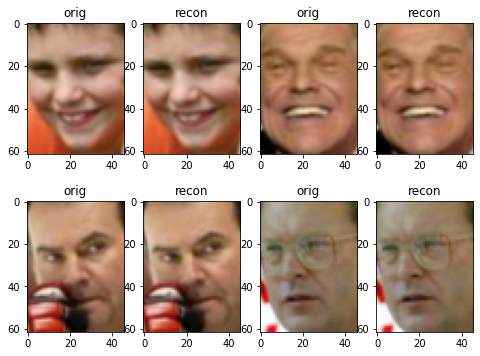

In [ ]:
iterable = iter(dataloader)
batch = next(iterable)
batch =  batch[0].cuda()
plot_tensor(batch, batch)

In [ ]:
class Logger:
    def __init__(self, metrics):
        self.metrics = {name:[0] for name in metrics}
    def update(self, name, value):
        self.metrics[name].append(value)
    def get(self, name):
        return self.metrics[name]
    def print_last(self):
        for name in self.metrics:
            print(f'{name} : {self.metrics[name][-1]}')
    def reset(self):
        for m in self.metrics:
            self.metrics[m] = [0]
    def avg(self,name):
        return  sum(self.metrics[name])/(len(self.metrics[name])-1)
        


logger = Logger(['total_loss','encoder_loss_z-e','decoder_loss_mse'])

In [ ]:
from IPython import display
import torch.optim as optim

def train_step(model, dataloader, optimizer, device):
    model.train()
    for batch in dataloader:
        batch = batch[0].to(device)
        optimizer.zero_grad()
        recon_im, losses = model(batch)    
        losses['total'].backward()
        optimizer.step()

        logger.update('total_loss', losses['total'].item())
        logger.update('encoder_loss_z-e', losses['encoder_loss'].item())
        logger.update('decoder_loss_mse', losses['decoder_loss'].item())
    
    return logger

def test(model,dataloader, device):
    batch = next(iter(dataloader))[0]
    batch = batch.to(device)
    out, _ = model(batch)
    plot_tensor(batch,out)

    indices = torch.tensor(range(128*4*4)).to(device)
    indices = indices.reshape(128,4,4)
    codes = model.quantize.embedding_KxDIM_C(indices).permute(0, 3, 1, 2)

    code_imgs  = model.decoder(codes)
    plot_tensor(code_imgs,code_imgs)

In [ ]:
params = {'model':{'DIM_IN':(3,62,46),
          'K':200,
          #'DIM_CODE':10
          },
          'lr':1e-5,
          'epochs':150}


use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = VQ_Vae(**params['model'])
optimizer = optim.Adam(model.parameters(), params['lr'])
def train(params):
    print(model)
    model.cuda()
    for i in range(params['epochs']):
        #if i%10 == 0:
            #test(model, dataloader, device)
            #display.clear_output(wait=3)
        losses = train_step(model, dataloader, optimizer, device)
        print(f' epoch: {i+1}',' '.join([str(m)+' '+str(logger.avg(m))  for m in logger.metrics]))
        losses.reset()
        #test(model,dataloader, device)


Quantizer dim code size  256
Encoder out sizes  (256, 4, 3)
Decoder intermediate sizes  (1, 1, 64, 48)


In [ ]:
train(params)

VQ_Vae(
  (encoder): ConvEncoder(
    (convs): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (quantize): Quantize(
    (embedding_KxDIM_C): Embedding(200, 256)
  )
  (decoder): ConvDecoder(
    (convs): Sequential(
      (0): ReLU()
      (1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (2): ReLU()
      (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
      (5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): ReLU()
      (7): ConvTr

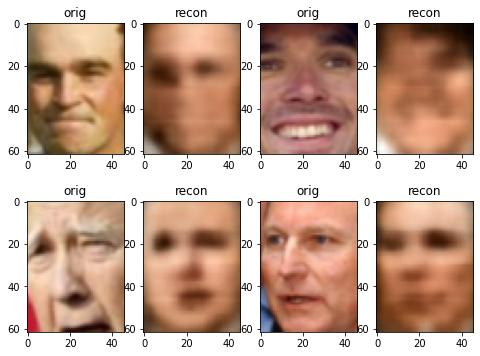

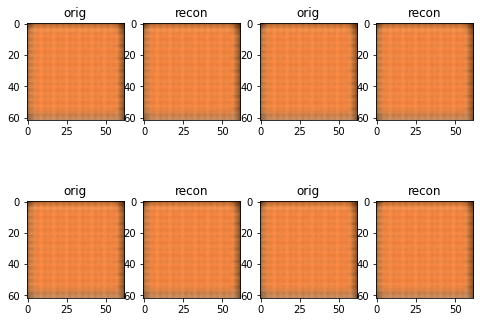

In [ ]:
test(model, dataloader, device)